**Nuclei segmentation in whole slide H&E images**

using custom model.

In [53]:
import numpy as np
import matplotlib.pyplot as plt

from tifffile import imread, imwrite
from csbdeep.utils import Path, normalize
from csbdeep.utils.tf import keras_import
keras = keras_import()

from stardist import export_imagej_rois, random_label_cmap
from stardist.models import StarDist2D

np.random.seed(0)
cmap = random_label_cmap()

In [2]:
import os
from glob import glob

pth = r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40'  # path of ndpi files
WSIs = sorted(glob(f'{pth}\*.ndpi'))

In [3]:
WSIs[:20]

['\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\monkey_fetus_40_0001.ndpi',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\monkey_fetus_40_0002.ndpi',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\monkey_fetus_40_0003.ndpi',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\monkey_fetus_40_0004.ndpi',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\monkey_fetus_40_0005.ndpi',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\monkey_fetus_40_0006.ndpi',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\monkey_fetus_40_0007.ndpi',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\monkey_fetus_40_0008.ndpi',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\monkey_fetus_40_0009.ndpi',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\monkey_fetus_40_0010.ndpi',
 '\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\monke

Load just 1 image and show (takes a couple min)

In [4]:
def show_image(img, crop_x, crop_y, tile_size, **kwargs):
    """Plot large image at different resolutions."""
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # Plot the original image on the left
    ax[0].imshow(img, **kwargs)

    # Crop the image
    cropped_img = img[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

    # Plot the cropped image on the right
    ax[1].imshow(cropped_img, **kwargs)

    ax[0].axis('off')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

In [5]:
from csbdeep.utils import normalize
import sys
from tqdm import tqdm

ind = 200  # which image in directory list you are loading

# you might need to run "pip install imagecodecs" if you get jpeg compression error

img = imread(WSIs[ind])
n_channel = 1 if img[0].ndim == 2 else img[0].shape[-1]  #If no third

img = img/255

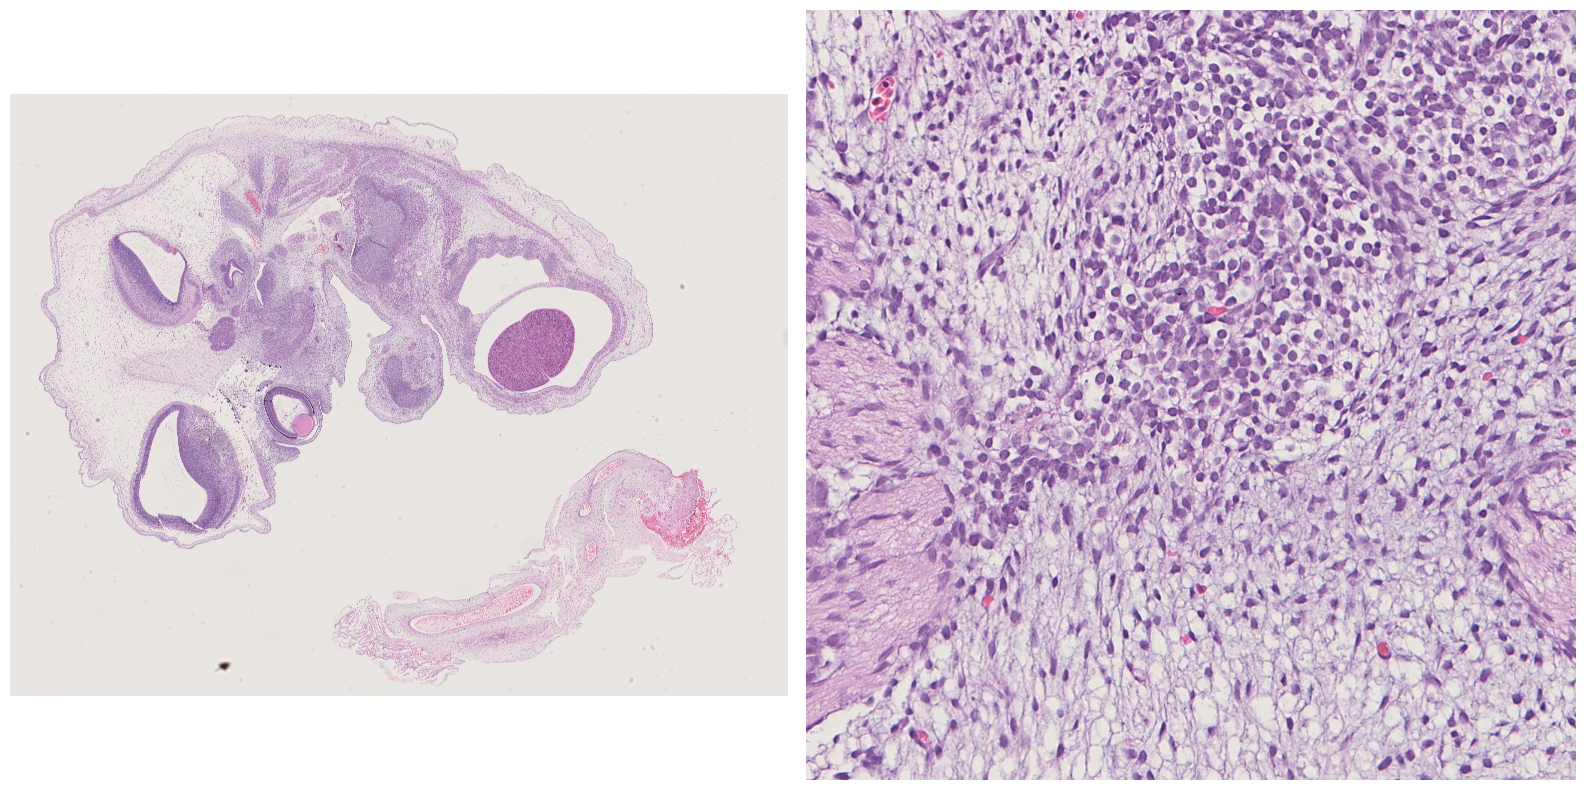

In [6]:
# display WSI image and also show a zoomed in region in a separate subplot
# show_image(img, crop_x=10000, crop_y=10000, tile_size=1024)

In [7]:
import json
from stardist.models import Config2D, StarDist2D

def load_model(model_path: str) -> StarDist2D:
    # Load StarDist model weights, configurations, and thresholds
    with open(model_path + '\\config.json', 'r') as f:
        config = json.load(f)
    with open(model_path + '\\thresholds.json', 'r') as f:
        thresh = json.load(f)
    model = StarDist2D(config=Config2D(**config), basedir=model_path, name='offshoot_model')
    model.thresholds = thresh
    print('Overriding defaults:', model.thresholds, '\n')
    model.load_weights(model_path + '\\weights_best.h5')
    return model

model = load_model(r"\\10.99.68.178\andreex\data\Stardist\qupath_training_annotations\models\monkey_ft_11_03_2023_lr_0.001_epochs_400_pt_40")

base_model.py (149): output path for model already exists, files may be overwritten: \\10.99.68.178\andreex\data\Stardist\qupath_training_annotations\models\monkey_ft_11_03_2023_lr_0.001_epochs_400_pt_40\offshoot_model


Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.7141860056664086, nms=0.3) 



To save prediction outputs, I save as geojson file.
By reading this template geojson file, I get the right type info that I need to save

In [10]:
n_channel = 1 if imread(WSIs[0]).ndim == 2 else imread(WSIs[0]).shape[-1]  #If no third

In [15]:
polys.keys()

dict_keys(['coord', 'points', 'prob'])

In [21]:
polys

{'coord': array([[[ 3550.        ,  3550.79980469,  3551.44897461, ...,
           3547.84521484,  3548.74487305,  3549.30175781],
         [ 1907.9597168 ,  1908.02038574,  1907.49780273, ...,
           1907.22473145,  1907.0300293 ,  1907.51037598]],
 
        [[ 1990.        ,  1990.64501953,  1991.19335938, ...,
           1987.66516113,  1988.61474609,  1989.27905273],
         [ 1943.52294922,  1943.24279785,  1942.88098145, ...,
           1943.4942627 ,  1943.34423828,  1943.62475586]],
 
        [[ 2738.        ,  2738.91186523,  2739.82714844, ...,
           2735.12353516,  2736.29321289,  2737.11914062],
         [ 7198.68017578,  7198.58447266,  7198.41088867, ...,
           7198.30493164,  7198.12060547,  7198.42797852]],
 
        ...,
 
        [[24942.        , 24942.56323242, 24943.08959961, ...,
          24940.21386719, 24940.98120117, 24941.44384766],
         [33600.94360352, 33600.83178711, 33600.63061523, ...,
          33600.67333984, 33600.45947266, 33600.79

In [54]:
import json

def save_json(result, out_pth, name):
    """Saves a geojson file with centroids and contours for StarDist output. Useful for loading into qupath"""
    coords = result['coord']
    points = result['points']

    json_data = []

    for i in range(len(points)):
        point = points[i]
        contour = coords[i]
        centroid = [int(point[0]), int(point[1])]
        contour = [[float(coord) for coord in xy[::-1]] for xy in contour]

        # Create a new dictionary for each contour
        dict_data = {
            "centroid": [centroid],
            "contour": [contour]
        }

        json_data.append(dict_data)

    new_fn = name[:-5] + '.json'

    with open(os.path.join(out_pth, new_fn),'w') as outfile:
        json.dump(json_data, outfile)
    print('Finished',new_fn)

In [62]:
# Segment all WSIs -- takes about 2-5 minutes per whole slide image to segment, about 3 minutes to save geojson file

date = '11_20_23'
out_pth_json = os.path.join(pth,f'StarDist_{date}','json')
out_pth_tif = os.path.join(pth,f'StarDist_{date}','tif')

if not os.path.exists(out_pth_json):
    os.mkdir(out_pth_json)

if not os.path.exists(out_pth_tif):
    os.mkdir(out_pth_tif)

for img_pth in WSIs:
    name = os.path.basename(img_pth)

    if not os.path.exists(os.path.join(out_pth_json, (name[:-5] + '.json'))):
        print(f'Starting {name}')

        img = imread(img_pth)
        img = img/255  # normalization used to train model
        labels, polys = model.predict_instances_big(img, axes='YXC', block_size=4096, min_overlap=128, context=128, n_tiles=(4,4,1))

        print('Saving json...')
        save_json(polys, out_pth_json, name)

        # tif file is like 3 GB usually, so only uncomment next part if you are ok with that
        #print('Saving tif...')
        #imwrite(os.path.join(out_pth_tif, name[:-5] + '.tif'), labels)
    else:
        print(f'Skipping {name}')

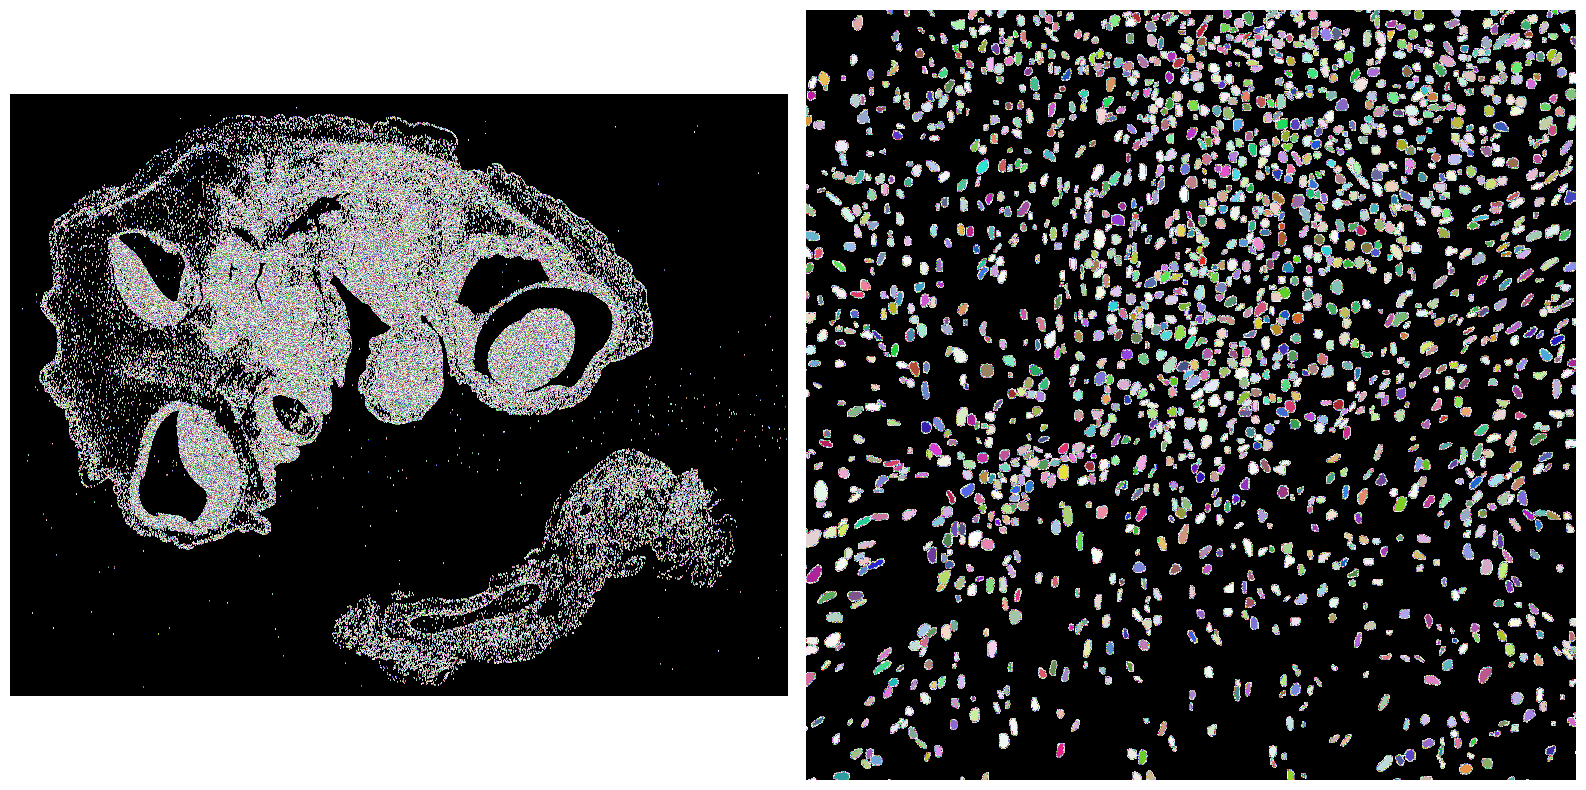

In [40]:
# show_image(labels, crop_x=10000, crop_y=10000, tile_size=1024, cmap=cmap)
# show_image(img, crop_x, crop_y, tile_size, cmap=cmap)

In [59]:
#cropped_img = img[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]
#cropped_lbl = labels[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

tile_size = 512*2

y_cor = 5100
y_cor_end = y_cor + tile_size
x_cor = 14200
x_cor_end = x_cor + tile_size

cropped_img = img[y_cor:y_cor_end, x_cor:x_cor_end]
cropped_lbl = labels[y_cor:y_cor_end, x_cor:x_cor_end]

lbl_cmap = random_label_cmap()

In [64]:
lbl_cmap.colors

array([[0.        , 0.        , 0.        ],
       [0.97197698, 0.96761729, 0.94296372],
       [0.7456422 , 0.39322   , 0.15125508],
       ...,
       [0.75349327, 0.51630844, 0.90994255],
       [0.48648676, 0.85933441, 0.43338316],
       [0.26232555, 0.55112257, 0.71991617]])

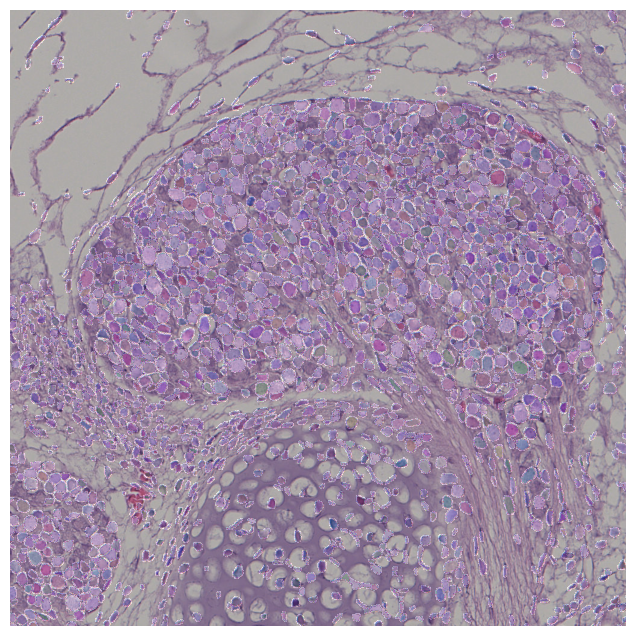

In [61]:
plt.figure(figsize=(8, 8))
plt.imshow(cropped_img, cmap='gray')
plt.imshow(cropped_lbl, cmap=lbl_cmap, alpha=0.25)
plt.axis('off')
plt.show()

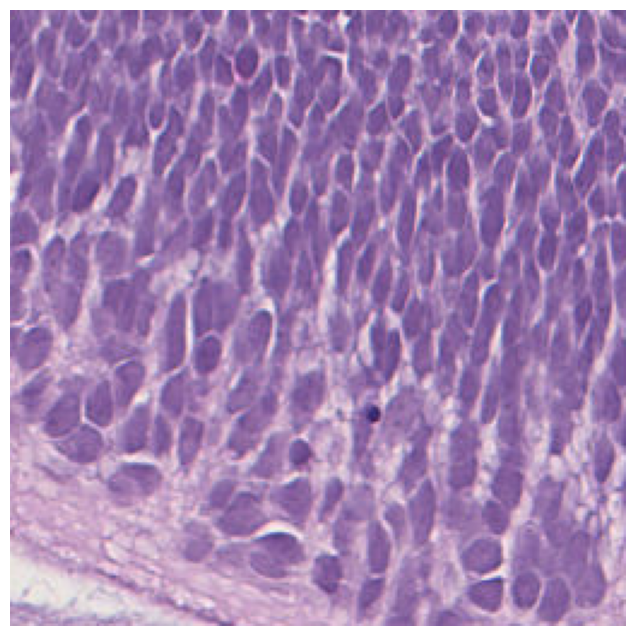

In [19]:
plt.figure(figsize=(8, 8))
plt.imshow(cropped_img)
plt.axis('off')
plt.show()

In [17]:
model_pre = StarDist2D.from_pretrained('2D_versatile_he')

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


In [18]:
labels_pre, polys_pre = model_pre.predict_instances_big(img, axes='YXC', block_size=4096, min_overlap=128, context=128, n_tiles=(4,4,1))

effective: block_size=(4096, 4096, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


100%|██████████| 90/90 [02:42<00:00,  1.81s/it]


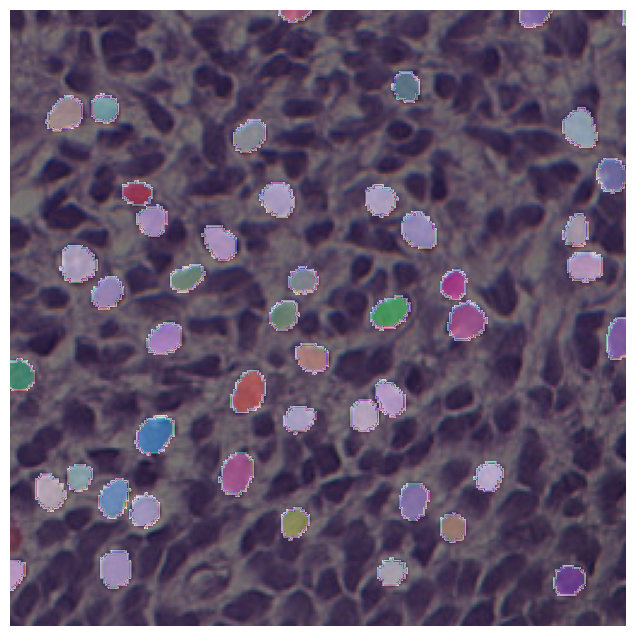

In [19]:
cropped_lbl_pre = labels_pre[y_cor:y_cor_end, x_cor:x_cor_end]

plt.figure(figsize=(8, 8))
plt.imshow(cropped_img, cmap='gray')
plt.imshow(cropped_lbl_pre, cmap=lbl_cmap, alpha=0.5)
plt.axis('off')
plt.show()

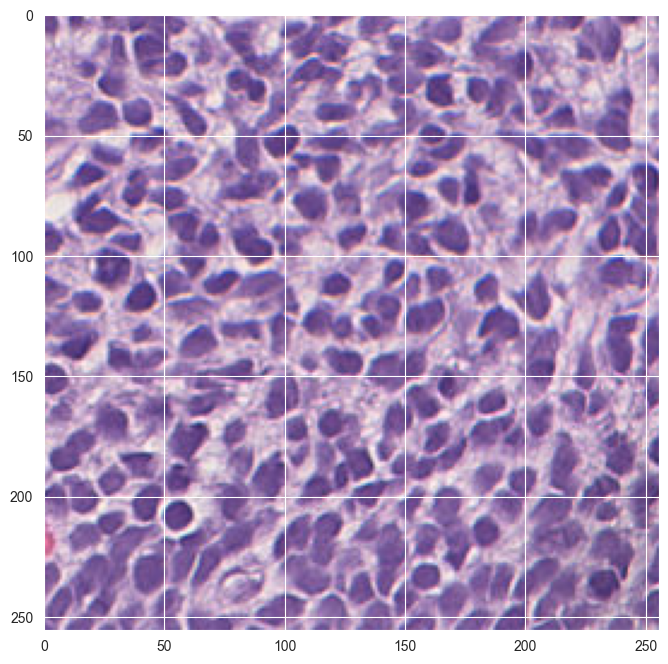

In [20]:
plt.figure(figsize=(8, 8))
plt.imshow(cropped_img)
plt.show()

Some quantifications

In [21]:
from skimage.measure import regionprops_table
import pandas as pd

In [22]:
# Slow - takes time as we have many many objects
props = regionprops_table(labels, img,
                          properties=['label',
                                      'area', 'equivalent_diameter',
                                      'mean_intensity', 'solidity'])


In [23]:
analysis_results = pd.DataFrame(props)
print(analysis_results.tail())

         label   area  equivalent_diameter  mean_intensity-0  \
609946  609947   41.0             7.225152          0.424868   
609947  609948   46.0             7.653040          0.527110   
609948  609949  129.0            12.815924          0.627755   
609949  609950   75.0             9.772050          0.360471   
609950  609951   82.0            10.217908          0.218651   

        mean_intensity-1  mean_intensity-2  solidity  
609946          0.499570          0.640937  0.872340  
609947          0.522762          0.683973  0.884615  
609948          0.572823          0.723332  0.977273  
609949          0.404863          0.544732  0.949367  
609950          0.221808          0.236442  0.987952  


In [24]:
import seaborn as sns

<Axes: xlabel='area', ylabel='Count'>

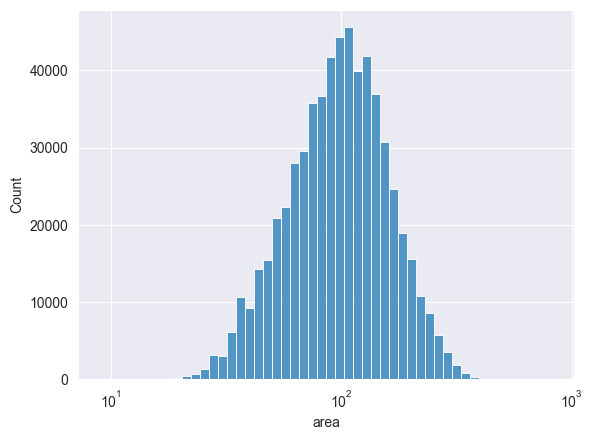

In [25]:
sns.histplot(x="area", data=analysis_results, bins=50, log_scale=True)